In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from time import time
import os

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('..')

import isolation
import sample_players
import run_match
import my_baseline_player as custom
import book as b

from multiprocessing.pool import ThreadPool as Pool

Populating the interactive namespace from numpy and matplotlib


/home/miguel/anaconda3/envs/aind/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Constant parameteres
time_limit = 150
depth = 4
full_search_depth = 2
matches_per_opening = 3

# Create the agents that will play
agent_names = ('CustomPlayer1', 'CustomPlayer2')
agent1 = isolation.Agent(custom.CustomPlayer, agent_names[0])
agent2 = isolation.Agent(custom.CustomPlayer, agent_names[1])
agents = (agent1, agent2)

# Get the initial states
root = isolation.isolation.Isolation()
opening_states = list(b.get_full_states(root, depth=full_search_depth))

# Generate the matches
matches = [(agents, state, time_limit, match_id) 
           for match_id, state in enumerate(opening_states)]
matches = matches * 3
print('Generated {} matches.'.format(len(matches)))

Generated 29403 matches.


In [3]:
num_processes = 4
batch_size = 100
batch_num_file = 'batch_num.txt'

# Small test for debugging
# matches = matches[:100]

# Create or load the book
book = b.load_latest_book(depth=depth)

# Make some batches to save the results once in a while
x = matches
batches = [x[i*batch_size:(i+1)*batch_size] 
           for i in range(len(x) // batch_size + (len(x) % batch_size != 0))]

# Get only the unprocessed batches
if os.path.exists(batch_num_file):
    with open(batch_num_file, 'r') as file:
        last_batch = int(file.read())
else:
    last_batch = -1

# Now fill the book!
pool = Pool(num_processes)

for batch_num in range(last_batch + 1, len(batches)):
    tic = time.time()
    batch = batches[batch_num]
    print('Processing batch {} of {}'.format(batch_num, len(batches)))
    for result in pool.imap_unordered(isolation.play, batch):
        winner, game_history, match_id = result
        # print('Results for match {}: {} wins.'.format(match_id, winner.name))
        _, state, _, _ = matches[match_id]
        if state.locs[1] is not None:
            game_history.insert(0,state.locs[1])
        if state.locs[0] is not None:
            game_history.insert(0,state.locs[0])
        root = isolation.isolation.Isolation()
        b.process_game_history(root,
                               game_history, 
                               book,
                               agent_names.index(winner.name),
                               active_player=state.ply_count % 2,
                               depth=depth)
    toc = time.time()
    print('Batch time {} seconds.'.format((toc-tic)))
    b.save_book(book)
    with open(batch_num_file, 'w') as file:
        file.write(str(batch_num))
    b.remove_old_books()

Processing batch 50 of 295
Batch time 273.42882919311523 seconds.
Saving: book2018-06-14_10S28S36.669105.pkl
rm book2018-06-13_23S12S33.790879.pkl
Processing batch 51 of 295
Batch time 281.39559602737427 seconds.
Saving: book2018-06-14_10S33S18.521569.pkl
rm book2018-06-14_10S28S36.669105.pkl
Processing batch 52 of 295
Batch time 279.23094749450684 seconds.
Saving: book2018-06-14_10S37S58.180333.pkl
rm book2018-06-14_10S33S18.521569.pkl
Processing batch 53 of 295
Batch time 280.1992733478546 seconds.
Saving: book2018-06-14_10S42S38.866531.pkl
rm book2018-06-14_10S37S58.180333.pkl
Processing batch 54 of 295
Batch time 297.19778847694397 seconds.
Saving: book2018-06-14_10S47S36.529465.pkl
rm book2018-06-14_10S42S38.866531.pkl
Processing batch 55 of 295
Batch time 298.93795824050903 seconds.
Saving: book2018-06-14_10S52S35.959086.pkl
rm book2018-06-14_10S47S36.529465.pkl
Processing batch 56 of 295
Batch time 295.12753224372864 seconds.
Saving: book2018-06-14_10S57S31.517046.pkl
rm book201

Process Process-716271:
Process Process-716268:
Process Process-716270:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/miguel/anaconda3/envs/aind/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process Process-716269:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/miguel/anaconda3/envs/aind/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/miguel/anaconda3/envs/aind/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/miguel/anaconda3/envs/aind/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/miguel/anaconda3/envs/aind/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/miguel/anaconda3/envs/aind/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._ar

KeyboardInterrupt: 

In [4]:
sum(abs(value) for value in book.values())

83082

In [ ]:
29403*34 / (10*3600)  # Estimated time in hours

In [5]:
import pandas as pd

v = pd.Series(list(book.values()))

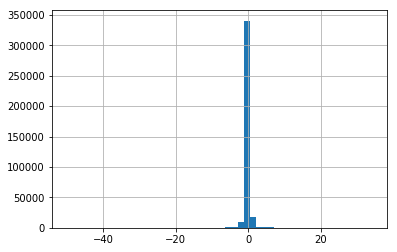

In [6]:
v.hist(bins=50)

In [7]:
v.describe()

count    374097.000000
mean         -0.001844
std           0.838411
min         -50.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          34.000000
dtype: float64

In [8]:
v.min()

-50

In [9]:
worst = min(((k, v) for k, v in book.items()), key=lambda x: x[1])
worst[0]

(Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
 55)

In [11]:
from isolation.isolation import Isolation
state = Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None))

print(isolation.DebugState.from_state(state.result(44)))


+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   | 1 |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +



What about the other symmetrical ones

In [12]:
s1 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 65)
s2 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 67)
s3 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 77)

In [13]:
book[s1]

-44

In [14]:
book[s2]

2

In [17]:
book[s3]

KeyError: (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 77)

### I think I have ply_count=1,2,3,4 in the book but not ply_count=0

In [18]:
len(book.items())

374097

In [16]:
s0 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 55)
book[s0]

-50

### Idea: show a heat matrix for the initial move